# This Code will Preprocess General Information

## Import Libraries

In [1]:
# import libraries
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import mediapipe as mp
import winsound
import random
import gzip
import pickle
import math

from ultralytics import YOLO
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from matplotlib import pyplot as plt

In [2]:
# play sound when training is done
def playSound():
    sound_file = "C:/Users/Lenovo/Documents/UMN/Semester 9/Data Modelling/week09/dinners.wav"

    winsound.PlaySound(sound_file, winsound.SND_ASYNC)

# stops the sound
def stopSound():
    winsound.PlaySound(None, winsound.SND_PURGE)

## Import Predefined Path

In [3]:
yolov11_detection_path = "./models/yolo11n.pt"
hand_landmarker_path = "./models/hand_landmarker.task"
pose_landmarker_path = "./models/pose_landmarker_heavy.task"

glossary_path = "./glossary.json"
dataset_dir = "./data"

output_rgb_dir = "./data-preprocess/rgb"
output_optical_flow_farneback_dir = "./data-preprocess/optical_flow_farneback"
output_optical_flow_tvl1_dir = "./data-preprocess/optical_flow_tvl1"
output_pose_dir = "./data-preprocess/pose"
output_base_dir = "./data-preprocess"

In [4]:
# if the output directories do not exist, create them
# base directories
if not os.path.exists(output_base_dir):
    os.makedirs(output_base_dir)
    
if not os.path.exists(output_rgb_dir):
    os.makedirs(output_rgb_dir)
if not os.path.exists(output_optical_flow_farneback_dir):
    os.makedirs(output_optical_flow_farneback_dir)
if not os.path.exists(output_optical_flow_tvl1_dir):
    os.makedirs(output_optical_flow_tvl1_dir)
if not os.path.exists(output_pose_dir):
    os.makedirs(output_pose_dir)

## Load Estimation Models

In [5]:
# for person recognition, we use yolov11
yolo_person_estimation_model = YOLO(yolov11_detection_path)

# for joint recognition, we use pose_landmarker from mediapipe
pose_base_options = python.BaseOptions(model_asset_path=pose_landmarker_path)
pose_options = vision.PoseLandmarkerOptions(base_options=pose_base_options, num_poses=1)
pose_predictor = vision.PoseLandmarker.create_from_options(pose_options)

# for hand joint recognition, we use hand_landmarker from mediapipe
hand_base_options = python.BaseOptions(model_asset_path=hand_landmarker_path)
hand_options = vision.HandLandmarkerOptions(base_options=hand_base_options, num_hands=2)
hand_predictor = vision.HandLandmarker.create_from_options(hand_options)

## Create / Load Glossary

In [6]:
# datasets consist of 2 depth folders: data -> verb -> word
# loads every file path in the dataset directory
dicts = []

if os.path.exists(glossary_path):
    with open(glossary_path, "r") as f:
        dicts = json.load(f)
    print("Glossary already exists. Loading from file.")
else:
    for verb in os.listdir(dataset_dir):
        verb_name = verb
        verb_path = os.path.join(dataset_dir, verb_name)
        for word in os.listdir(verb_path):
            word_name = word
            word_path = os.path.join(verb_path, word_name)
            for file in os.listdir(word_path):
                file_path = os.path.join(word_path, file)
                dicts.append({
                    "verb": verb_name,
                    "word": word_name,
                    "file_path": file_path,
                    "file_name": file,
                    "file_id": file.split(".")[0],
                })

    # save this as a json file
    with open("glossary.json", "w") as f:
        json.dump(dicts, f, indent=4)
        # replace dicts' file_path \\ with /
        for d in dicts:
            d["file_path"] = d["file_path"].replace("\\", "/")

Glossary already exists. Loading from file.


## Preprocess Preview

In [7]:
# get 4 samples from the dataset
samples = random.sample(dicts, 4)

lsts = []

# for each sample, we will process the video
for sample in samples:
    print(f"Processing {sample['file_path']}...")
    cap = cv2.VideoCapture(sample["file_path"])
    frames = []
    if not cap.isOpened():
        print(f"Error opening video file {sample['file_path']}")
        continue

    # read the video frames
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # convert the frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)

    cap.release()
    lsts.append(frames)

Processing ./data\Kata Sifat\Baik\BISINDO_Kata Sifat_Baik_28.mp4...
Processing ./data\Kata Lainnya\Terima Kasih\BISINDO_Kata Lainnya_Terima Kasih_16.mp4...
Processing ./data\5W+1H\Siapa\BISINDO_5W+1H_Siapa_32.mp4...
Processing ./data\Kata Lainnya\Hari Ini\BISINDO_Kata Lainnya_Hari Ini_3.mov...


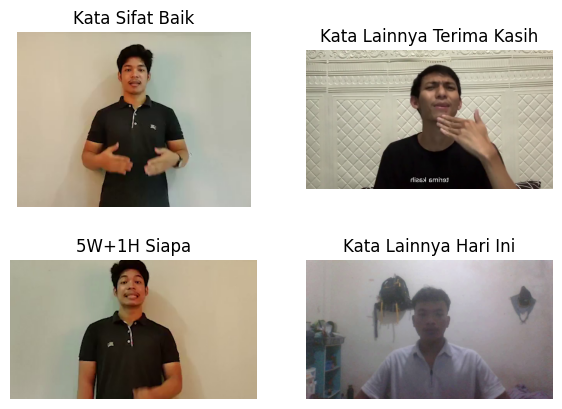

In [8]:
plt.figure(figsize=(7, 5))
plt.subplot(2, 2, 1)
for i, sample in enumerate(samples):
    plt.subplot(2, 2, i + 1)
    plt.imshow(lsts[i][0])
    plt.title(f"{sample['verb']} {sample['word']}")
    plt.axis("off")

In [9]:
# using random sample and random frame to select a random file from the dataset
dictsIndex = random.randint(0, len(dicts) - 1)
sample = dicts[dictsIndex]

cap = cv2.VideoCapture(sample["file_path"])
# assuming video is opened successfully, so no error here

max_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# starts from frame 1 to max_frames - 1, previous frame is used to calculate optical flow
frame_idx = random.randint(1, max_frames - 1)
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    # convert frame to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

frame = frames[frame_idx]
prev_frame = frames[frame_idx - 1]

### YOLOv11 Cropping

Text(0.5, 1.0, 'Verb: 5W+1H, Word: Siapa')

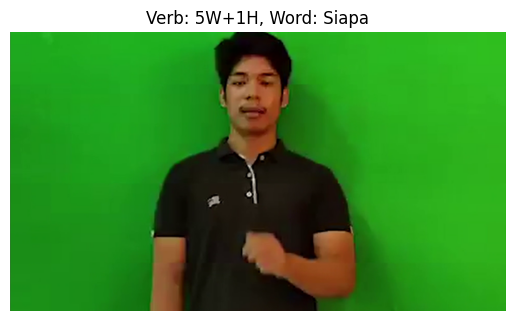

In [10]:
plt.imshow(frame)
plt.axis('off')
plt.title(f"Verb: {sample['verb']}, Word: {sample['word']}")

In [ ]:
# Predict bounding box
results = yolo_person_estimation_model.predict(source=frame, conf=0.5, save=False, verbose=False)
if len(results) == 0:
    print("No person detected in the frame.")
    exit()

center_x, center_y, width, height = results[0].boxes.xywh[0]
x1, y1, x2, y2 = results[0].boxes.xyxy[0]

area_factor = math.sqrt(2)  # Area multiplier (√2)
linear_factor = math.sqrt(area_factor)  # Linear scaling (√(√2) ≈ 1.189)

# Apply linear scaling factor
new_width = width * linear_factor
new_height = height * linear_factor

# Calculate new coordinates (centered)
e_x1 = center_x - new_width / 2
e_y1 = center_y - new_height / 2
e_x2 = center_x + new_width / 2
e_y2 = center_y + new_height / 2

# Clamp to image dimensions
h, w = frame.shape[:2]
e_x1 = max(0, e_x1)
e_y1 = max(0, e_y1)
e_x2 = min(w, e_x2)
e_y2 = min(h, e_y2)

frame_copy = frame.copy()
cv2.rectangle(frame_copy, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)  # Original
cv2.putText(frame_copy, "Original", (int(x1), int(y1) + 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
cv2.rectangle(frame_copy, (int(e_x1), int(e_y1)), (int(e_x2), int(e_y2)), (255, 0, 0), 2)  # Enlarged
cv2.putText(frame_copy, "Enlarged", (int(e_x1), int(e_y1) + 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
plt.imshow(frame_copy)
plt.axis('off')
plt.title(f"Person Bounding Box: {sample['verb']}, {sample['word']}")

### Optical Flow Extraction

In [19]:
def calculateOpticalFlowFarneback(prev_frame, frame):
    # convert frames to grayscale
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow using Farneback method
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    return flow

def calculateOpticalFlowTvl1(frames: list):
    """Calculate optical flow using the TV-L1 method."""
    # Initialize the TV-L1 optical flow object
    tvl1 = cv2.optflow.DualTVL1OpticalFlow_create()

    # Convert frames to grayscale
    prev_gray = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
    flow = []

    for i in range(1, len(frames)):
        gray = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
        # Calculate optical flow
        flow.append(tvl1.calc(prev_gray, gray, None))
        prev_gray = gray

    return flow

# get optical flow using farneback method
def getOpticalFlow(frames: list):
    # add extra frame at the end to match the length
    frames.append(frames[-1])
    optical_flow = []
    prev_gray = None

    for frame in frames:
        if prev_gray is None:
            prev_gray = frame
            continue
        
        flow = calculateOpticalFlowFarneback(prev_gray, frame)
        optical_flow.append(flow)
        
        prev_gray = frame

    return optical_flow

# function to visualize optical flow
def visualize_flow_hsv(flow, actual_frame):
    """Convert flow to HSV color space for intuitive visualization."""
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 1] = 255  # Max saturation
    
    # Convert flow to polar coordinates (angle and magnitude)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue = direction (0-180°)
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value = speed
    
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    plt.subplot(1, 2, 1)
    plt.imshow(actual_frame)  # Show the first frame for reference
    plt.title('Original Frame')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(rgb)
    plt.title('Optical Flow (HSV Color Coding)')
    plt.axis('off')
    plt.show()

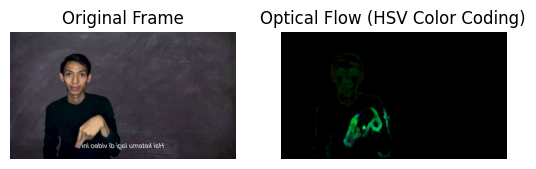

In [20]:
flow = calculateOpticalFlowFarneback(prev_frame, frame)

# visualize optical flow
visualize_flow_hsv(flow, frame)

## Preprocess

In [12]:
def forceFrames(frames: list, target_length=64) -> list:
    """
    Preprocess video by adding a padding if the number of frames is less than target_length. And resize each frame to target_size.
    """
    frame_count = len(frames)
    if frame_count < target_length:
        # Randomly choose to pad with first or last frame
        randInt = random.randint(0, 1) # if 1, pad with last frame, else pad with first frame
        pad_frame = frames[0] if randInt == 0 else frames[-1]
        # Create padding frames
        padding = [pad_frame] * (target_length - frame_count)
        if randInt == 0:
            frames = padding + frames
        else:
            frames = frames + padding
    elif frame_count > target_length:
        # Randomly select a starting index to cut the video
        start_idx = np.random.randint(0, frame_count - target_length + 1)
        frames = frames[start_idx : start_idx + target_length]

    return frames

def loadFrameFromVideoPath(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Error: Could not open video {video_path}")
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    for idx in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        _, frame = cap.read()
        if frame is not None:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
            frames.append(frame)        

    cap.release()

    return frames

def preprocess_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Error: Could not open video {video_path}")
    
    frames = loadFrameFromVideoPath(video_path)
    
    predictions = yolo_person_estimation_model.predict(source=frames, save=False, verbose=False, stream=False)

    cropped_frames = []
    prev_pred = None
    for idx, prediction in enumerate(predictions):
        frame = frames[idx]
        if len(prediction.boxes) == 0:
            # uses the previous prediction if no person is detected
            if prev_pred is None:
                raise ValueError("No person detected in the video frames.")
            center_x, center_y, width, height = prev_pred
        else:
            center_x, center_y, width, height = prediction.boxes.xywh[0]

        linear_factor = math.sqrt(area_factor)  # Linear scaling (√(√2) ≈ 1.189)

        # Apply linear scaling factor
        new_width = width * linear_factor
        new_height = height * linear_factor

        e_x1 = center_x - new_width / 2
        e_y1 = center_y - new_height / 2
        e_x2 = center_x + new_width / 2
        e_y2 = center_y + new_height / 2

        # Clamp to image dimensions
        h, w = frame.shape[:2]
        e_x1 = max(0, e_x1)
        e_y1 = max(0, e_y1)
        e_x2 = min(w, e_x2)
        e_y2 = min(h, e_y2)

        # crop the bounding box
        cropped_frame = frame[int(e_y1):int(e_y2), int(e_x1):int(e_x2)]
        # resize to 256x256
        cropped_frame = cv2.resize(cropped_frame, (256, 256))
        cropped_frames.append(cropped_frame)
        prev_pred = (center_x, center_y, width, height)

    return cropped_frames

In [13]:
# only includes left/right shoulder and elbow
body_pose_lookup = [14, 12, 11, 13]
body_pose_joints = [[14, 12], [12, 11], [11, 13]]

# uses all hand poses
hand_pose_joints = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [0, 5],
    [5, 6],
    [6, 7],
    [7, 8],
    [5, 9],
    [9, 10],
    [10, 11],
    [11, 12],
    [13, 14],
    [14, 15],
    [15, 16],
    [13, 17],
    [17, 18],
    [18, 19],
    [19, 20],
    [0, 17]
]

def predict_pose_and_hand_keypoints(results_pose: list, results_hand: list):
    """
    Predict the pose and hand keypoints from the MediaPipe result.
    Returns a dictionary with pose keypoints and hand keypoints.
    """
    pose_keypoints = []
    left_hand_keypoints = []
    right_hand_keypoints = []

    for result in results_hand:
        left_hand = np.zeros((21, 3), dtype=np.float16)
        right_hand = np.zeros((21, 3), dtype=np.float16)

        for idx, handedness in enumerate(result.handedness):
            list_hand = []

            for landmark in result.hand_landmarks[idx]:
                list_hand.append((landmark.x, landmark.y, landmark.z))
            
            if handedness[0].index == 0:  # left hand
                left_hand = np.array(list_hand, dtype=np.float16)
            if handedness[0].index == 1: # right hand
                right_hand = np.array(list_hand, dtype=np.float16)
        
        left_hand_keypoints.append(left_hand)
        right_hand_keypoints.append(right_hand)

    # Extract pose keypoints
    for result in results_pose:
        pose = []  # 4 joints, 3 coordinates (x, y, z)
        # check if pose_landmarks is not empty
        if not result.pose_landmarks:
            # if no pose landmarks detected, append zeroes
            pose = np.zeros((4, 3), dtype=np.float16)
        else:
            for idx, landmark in enumerate(result.pose_landmarks[0]):
                if idx not in body_pose_lookup:
                    continue
                pose.append((landmark.x, landmark.y, landmark.z))
    
        pose_keypoints.append(pose)

    return {
        "pose": np.array(pose_keypoints, dtype=np.float16),
        "left_hand": np.array(left_hand_keypoints, dtype=np.float16),
        "right_hand": np.array(right_hand_keypoints, dtype=np.float16)
    }

## Create Preprocessed Dataset

Note:
- the file will use .pkl.gz extension (pickle + gzip method) to reduce file size
- the code will continue from previous progress so no replace or duplicate

### RGB Preprocessing

In [14]:
try:
    out_dir_pose_list = os.listdir(output_rgb_dir)
    # filter to no ext
    out_dir_pose_list = [f.split(".")[0] for f in out_dir_pose_list]
    for (iii, gloss) in enumerate(dicts):
        # skip if the file already exists in the output directory
        if gloss["file_id"] in out_dir_pose_list:
            continue

        print(f"processing video {gloss["file_id"]} ({iii + 1}/{len(dicts)})")
        preprocessed_rgb = preprocess_video(gloss["file_path"])
        print(f"len: {len(preprocessed_rgb)} frames")
    
        # save the video
        filename = gloss["file_id"] + ".pkl.gz"
        out_path = os.path.join(output_rgb_dir, filename)

        with gzip.open(out_path, "wb") as f:
            pickle.dump(preprocessed_rgb, f, protocol=pickle.HIGHEST_PROTOCOL)
finally:
    playSound()

processing video BISINDO_5W+1H_Apa_11 (1/290)
len: 69 frames
processing video BISINDO_5W+1H_Apa_18 (2/290)
len: 47 frames
processing video BISINDO_5W+1H_Apa_29 (3/290)
len: 57 frames
processing video BISINDO_5W+1H_Apa_3 (4/290)
len: 57 frames
processing video BISINDO_5W+1H_Apa_30 (5/290)
len: 64 frames
processing video BISINDO_5W+1H_Apa_31 (6/290)
len: 33 frames
processing video BISINDO_5W+1H_Apa_33 (7/290)
len: 34 frames
processing video BISINDO_5W+1H_Apa_35 (8/290)
len: 33 frames
processing video BISINDO_5W+1H_Apa_43 (9/290)
len: 74 frames
processing video BISINDO_5W+1H_Bagaimana_1 (10/290)
len: 57 frames
processing video BISINDO_5W+1H_Bagaimana_12 (11/290)
len: 69 frames
processing video BISINDO_5W+1H_Bagaimana_14 (12/290)
len: 60 frames
processing video BISINDO_5W+1H_Bagaimana_18 (13/290)
len: 30 frames
processing video BISINDO_5W+1H_Bagaimana_24 (14/290)
len: 80 frames
processing video BISINDO_5W+1H_Bagaimana_30 (15/290)
len: 73 frames
processing video BISINDO_5W+1H_Dimana-Kemana_

### Optical Flow Preprocessing

### Farneback

In [15]:
try:
    out_dir_pose_list = os.listdir(output_optical_flow_farneback_dir)
    # filter to no ext
    out_dir_pose_list = [f.split(".")[0] for f in out_dir_pose_list]
    for (iii, gloss) in enumerate(dicts):
        # skip if the file already exists in the output directory
        if gloss["file_id"] in out_dir_pose_list:
            continue

        print(f"processing video {gloss["file_id"]} ({iii + 1}/{len(dicts)})")

        # get from the preprocessed rgb video
        path_rgb = os.path.join(output_rgb_dir, gloss["file_id"] + ".pkl.gz")
        with gzip.open(path_rgb, "rb") as f:
            frames = pickle.load(f)
            
        optical_flow = getOpticalFlow(frames)
    
        # save the video
        filename = gloss["file_id"] + ".pkl.gz"
        out_path = os.path.join(output_optical_flow_farneback_dir, filename)

        with gzip.open(out_path, "wb") as f:
            pickle.dump(optical_flow, f, protocol=pickle.HIGHEST_PROTOCOL)
finally:
    playSound()

processing video BISINDO_5W+1H_Apa_11 (1/290)
processing video BISINDO_5W+1H_Apa_18 (2/290)
processing video BISINDO_5W+1H_Apa_29 (3/290)
processing video BISINDO_5W+1H_Apa_3 (4/290)
processing video BISINDO_5W+1H_Apa_30 (5/290)
processing video BISINDO_5W+1H_Apa_31 (6/290)
processing video BISINDO_5W+1H_Apa_33 (7/290)
processing video BISINDO_5W+1H_Apa_35 (8/290)
processing video BISINDO_5W+1H_Apa_43 (9/290)
processing video BISINDO_5W+1H_Bagaimana_1 (10/290)
processing video BISINDO_5W+1H_Bagaimana_12 (11/290)
processing video BISINDO_5W+1H_Bagaimana_14 (12/290)
processing video BISINDO_5W+1H_Bagaimana_18 (13/290)
processing video BISINDO_5W+1H_Bagaimana_24 (14/290)
processing video BISINDO_5W+1H_Bagaimana_30 (15/290)
processing video BISINDO_5W+1H_Dimana-Kemana_10 (16/290)
processing video BISINDO_5W+1H_Dimana-Kemana_17 (17/290)
processing video BISINDO_5W+1H_Dimana-Kemana_25 (18/290)
processing video BISINDO_5W+1H_Dimana-Kemana_28 (19/290)
processing video BISINDO_5W+1H_Dimana-Kema

### TV-L1

In [ ]:
try:
    out_dir_pose_list = os.listdir(output_optical_flow_tvl1_dir)
    # filter to no ext
    out_dir_pose_list = [f.split(".")[0] for f in out_dir_pose_list]
    for (iii, gloss) in enumerate(dicts):
        # skip if the file already exists in the output directory
        if gloss["file_id"] in out_dir_pose_list:
            continue

        print(f"processing video {gloss["file_id"]} ({iii + 1}/{len(dicts)})")

        # get from the preprocessed rgb video
        path_rgb = os.path.join(output_rgb_dir, gloss["file_id"] + ".pkl.gz")
        with gzip.open(path_rgb, "rb") as f:
            frames = pickle.load(f)
            
        optical_flow = calculateOpticalFlowTvl1(frames)
    
        # save the video
        filename = gloss["file_id"] + ".pkl.gz"
        out_path = os.path.join(output_optical_flow_tvl1_dir, filename)

        with gzip.open(out_path, "wb") as f:
            pickle.dump(optical_flow, f, protocol=pickle.HIGHEST_PROTOCOL)
finally:
    playSound()

processing video BISINDO_5W+1H_Apa_11 (1/290)
processing video BISINDO_5W+1H_Apa_18 (2/290)
processing video BISINDO_5W+1H_Apa_29 (3/290)
processing video BISINDO_5W+1H_Apa_3 (4/290)
processing video BISINDO_5W+1H_Apa_30 (5/290)
processing video BISINDO_5W+1H_Apa_31 (6/290)
processing video BISINDO_5W+1H_Apa_33 (7/290)
processing video BISINDO_5W+1H_Apa_35 (8/290)
processing video BISINDO_5W+1H_Apa_43 (9/290)
processing video BISINDO_5W+1H_Bagaimana_1 (10/290)
processing video BISINDO_5W+1H_Bagaimana_12 (11/290)
processing video BISINDO_5W+1H_Bagaimana_14 (12/290)
processing video BISINDO_5W+1H_Bagaimana_18 (13/290)
processing video BISINDO_5W+1H_Bagaimana_24 (14/290)
processing video BISINDO_5W+1H_Bagaimana_30 (15/290)
processing video BISINDO_5W+1H_Dimana-Kemana_10 (16/290)
processing video BISINDO_5W+1H_Dimana-Kemana_17 (17/290)
processing video BISINDO_5W+1H_Dimana-Kemana_25 (18/290)
processing video BISINDO_5W+1H_Dimana-Kemana_28 (19/290)
processing video BISINDO_5W+1H_Dimana-Kema

### Pose Keypoint Preprocessing

In [ ]:
try:
    out_dir_pose_list = os.listdir(output_pose_dir)
    # turn \\ to /
    out_dir_pose_list = [f.replace("\\", "/") for f in out_dir_pose_list]
    # filter to no ext
    out_dir_pose_list = [f.split(".")[0] for f in out_dir_pose_list]
    for (iii, gloss) in enumerate(dicts):
        # skip if the file already exists in the output directory
        if gloss["file_id"] in out_dir_pose_list:
            continue

        print(f"processing video {gloss["file_id"]} ({iii + 1}/{len(dicts)})")
        # get from the preprocessed rgb video
        path_rgb = os.path.join(output_rgb_dir, gloss["file_id"] + ".pkl.gz")
        with gzip.open(path_rgb, "rb") as f:
            frames = pickle.load(f)

        # predicting pose and hand keypoints
        pose_preds = []
        hand_preds = []
        for frame in frames:
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
            hand_preds.append(hand_predictor.detect(mp_image))
            pose_preds.append(pose_predictor.detect(mp_image))

        pose_pred_res = predict_pose_and_hand_keypoints(pose_preds, hand_preds)

        # save the video
        filename = gloss["file_id"] + ".pkl.gz"
        out_path = os.path.join(output_pose_dir, filename)

        with gzip.open(out_path, "wb") as f:
            pickle.dump(pose_pred_res, f, protocol=pickle.HIGHEST_PROTOCOL)
finally:
    playSound()

processing video BISINDO_5W+1H_Apa_11 (1/290)
processing video BISINDO_5W+1H_Apa_18 (2/290)
processing video BISINDO_5W+1H_Apa_29 (3/290)
processing video BISINDO_5W+1H_Apa_3 (4/290)
processing video BISINDO_5W+1H_Apa_30 (5/290)
processing video BISINDO_5W+1H_Apa_31 (6/290)
processing video BISINDO_5W+1H_Apa_33 (7/290)
processing video BISINDO_5W+1H_Apa_35 (8/290)
processing video BISINDO_5W+1H_Apa_43 (9/290)
processing video BISINDO_5W+1H_Bagaimana_1 (10/290)
processing video BISINDO_5W+1H_Bagaimana_12 (11/290)
processing video BISINDO_5W+1H_Bagaimana_14 (12/290)
processing video BISINDO_5W+1H_Bagaimana_18 (13/290)
processing video BISINDO_5W+1H_Bagaimana_24 (14/290)
processing video BISINDO_5W+1H_Bagaimana_30 (15/290)
processing video BISINDO_5W+1H_Dimana-Kemana_10 (16/290)
processing video BISINDO_5W+1H_Dimana-Kemana_17 (17/290)
processing video BISINDO_5W+1H_Dimana-Kemana_25 (18/290)
processing video BISINDO_5W+1H_Dimana-Kemana_28 (19/290)
processing video BISINDO_5W+1H_Dimana-Kema

In [18]:
optflow_path = "./data-preprocess/optical_flow_farneback/"

In [19]:
# load all optical flow data
for (iii, gloss) in enumerate(dicts):
    print(f"loading optical flow data {gloss['file_id']} ({iii + 1}/{len(dicts)})")
    path_optical_flow = os.path.join(output_optical_flow_farneback_dir, gloss["file_id"] + ".pkl.gz")
    with gzip.open(path_optical_flow, "rb") as f:
        optical_flow = pickle.load(f)

    # turn optical flow into numpy array
    optical_flow = np.array(optical_flow, dtype=np.float16)

    # replace the file content with the optical flow data
    with gzip.open(path_optical_flow, "wb") as f:
        pickle.dump(optical_flow, f, protocol=pickle.HIGHEST_PROTOCOL)

loading optical flow data BISINDO_5W+1H_Apa_11 (1/290)
loading optical flow data BISINDO_5W+1H_Apa_18 (2/290)
loading optical flow data BISINDO_5W+1H_Apa_29 (3/290)
loading optical flow data BISINDO_5W+1H_Apa_3 (4/290)
loading optical flow data BISINDO_5W+1H_Apa_30 (5/290)
loading optical flow data BISINDO_5W+1H_Apa_31 (6/290)
loading optical flow data BISINDO_5W+1H_Apa_33 (7/290)
loading optical flow data BISINDO_5W+1H_Apa_35 (8/290)
loading optical flow data BISINDO_5W+1H_Apa_43 (9/290)
loading optical flow data BISINDO_5W+1H_Bagaimana_1 (10/290)
loading optical flow data BISINDO_5W+1H_Bagaimana_12 (11/290)
loading optical flow data BISINDO_5W+1H_Bagaimana_14 (12/290)
loading optical flow data BISINDO_5W+1H_Bagaimana_18 (13/290)
loading optical flow data BISINDO_5W+1H_Bagaimana_24 (14/290)
loading optical flow data BISINDO_5W+1H_Bagaimana_30 (15/290)
loading optical flow data BISINDO_5W+1H_Dimana-Kemana_10 (16/290)
loading optical flow data BISINDO_5W+1H_Dimana-Kemana_17 (17/290)
loa